In [49]:
%load_ext autoreload
%autoreload 2

In [1]:
def replace_unet_in_pipeline(pipe, path_to_weights=None, device='cuda'):
    unet = pipe.unet
    tmp = unet.conv_out
    n_noise_pred_channels = unet.conv_out.out_channels

    new_layer =  torch.nn.Conv2d(tmp.in_channels, tmp.out_channels * 2, kernel_size=tmp.kernel_size, padding=tmp.padding, bias=True, dtype=torch.float16) # Add 2 channels to serve for segmentation
    if path_to_weights:
        # load weights
        chkpt = torch.load(path_to_weights)
        new_layer.load_state_dict(chkpt['conv_out_state_dict'])
    else:
        # init weights to pipe weights
        new_layer.weight.data[:tmp.weight.data.shape[0], :, :, :] = tmp.weight.data[:, :, :, :]
    new_layer.to(device=device)
    unet.conv_out = new_layer
    return

import xml.etree.ElementTree as ET
import os

def get_annotations(img_paths, annotations_root):
    voc_classes = {'background' : 'background',
                    'aeroplane' : 'aeroplane',
                    'bicycle' : 'bicycle',
                    'bird' : 'bird',
                    'boat' : 'boat',
                    'bottle' : 'bottle',
                    'bus' : 'bus',
                    'car' : 'car',
                    'cat' : 'cat',
                    'chair' : 'chair',
                    'cow' : 'cow',
                    'diningtable' : 'dining table',
                    'dog' : 'dog',
                    'horse' : 'horse',
                    'motorbike' : 'motorbike',
                    'person' : 'person',
                    'pottedplant' : 'potted plant',
                    'sheep' : 'sheep',
                    'sofa' : 'sofa',
                    'train' : 'train',
                    'tvmonitor' : 'tv monitor'}

    images_names = [os.path.splitext(os.path.basename(path))[0] for path in img_paths]
    xmls_paths = [os.path.join(annotations_root, img_name +'.xml') for img_name in images_names]
    
    annotations = []
    for path in xmls_paths:
        tree = ET.parse(path)
        root = tree.getroot()
        annontation = root.find('object/name')

        annotations += [voc_classes[annontation.text]]

    return annotations

# Sample random pics and get their seg
import os
from os import walk
import random

def diffuse_random_imgs(img_folder, pipe, prompt, strength, guidance,neg_prompt=None, save_path=None):
    N_PICS = 9
    f = next(walk(img_folder), (None, None, []))[2]
    filenames = [os.path.join(img_folder, filename) for filename in f]
    filenames = random.sample(filenames, N_PICS)
    annotations_root = '/disk4/Lev/Projects/diffusion_finetuning/data/Annotations/'
    annotations = get_annotations(filenames, annotations_root)

    fig , ax = plt.subplots(N_PICS, 2,figsize=(15, 40))
    for i, item in enumerate(zip(filenames, annotations)):
        f, annotation = item
        init_image = Image.open(f).convert("RGB").resize((512, 512))
        ax[i, 0].imshow(init_image, aspect='auto')
        ax[i, 0].axis('off')
        
        full_prompt = prompt + ' ' + annotation
        image = pipe(prompt=full_prompt, image=init_image, strength=strength, guidance_scale=guidance, modified_unet=True, segmentation=True).images[0]
        ax[i, 1].imshow(image, aspect='auto')
        ax[i, 1].axis('off')
        ax[i, 1].set_title(full_prompt + ' ' + f)

        if save_path:
            if not os.path.exists(save_path):       
                os.mkdir(save_path)
            init_image.save(os.path.join(save_path, 'original_' + os.path.basename(f)))
            image.save(os.path.join(save_path, os.path.basename(f)))

    plt.show()



In [2]:
def get_good_slices(arr, s_indx=0):
    slices = []
    for i in range(s_indx, len(arr)):
        if arr[i].max() > 0:
            slices.append(i)
    return slices

## Test Segmentation

In [3]:
import os
from PIL import Image
from torchvision import transforms
import matplotlib.pyplot as plt
#@title LOADING MODEL AND MONKEY PATCHING IT
import torch
import numpy as np
from lora_diffusion import monkeypatch_lora, tune_lora_scale
from diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion_img2img import StableDiffusionImg2ImgPipeline

PATH_PREFIX = '/disk4/Lev/Projects/diffusion_finetuning/output/lits17/w_text/ct_liver_segmentation_good_slices_only_run1'
UNET_WEIGHTS_PATH = os.path.join(PATH_PREFIX, 'unet_seg_weights.pt')
LORA_WEIGHTS_PATH = os.path.join(PATH_PREFIX, 'lora_weight.pt')
LORA_TEXT_WEIGHTS_PATH = os.path.join(PATH_PREFIX,'lora_weight.text_encoder.pt')

model_id = "stabilityai/stable-diffusion-2-1-base"
torch.cuda.empty_cache()
pipe = StableDiffusionImg2ImgPipeline.from_pretrained(model_id, torch_dtype=torch.float16).to('cuda:3')

monkeypatch_lora(pipe.unet, torch.load(LORA_WEIGHTS_PATH))
monkeypatch_lora(pipe.text_encoder, torch.load(LORA_TEXT_WEIGHTS_PATH), target_replace_module=["CLIPAttention"])

tune_lora_scale(pipe.unet, 1.5)
tune_lora_scale(pipe.text_encoder, 1)

replace_unet_in_pipeline(pipe, UNET_WEIGHTS_PATH, device=pipe.device)


/opt/miniconda3/envs/lev/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Fetching 16 files: 100%|██████████| 16/16 [00:00<00:00, 10025.23it/s]


In [4]:
import SimpleITK as sitk
import matplotlib.pyplot as plt
import random
import os

n = 10
PATH = '/disk4/Lev/Projects/diffusion_finetuning/data/lits17/test/'
seg_path = os.path.join(PATH,f'segmentation-{n}.nii')
path = os.path.join(PATH,f'volume-{n}.nii')

img = sitk.ReadImage(path, sitk.sitkUInt8)
seg_img = sitk.ReadImage(seg_path, sitk.sitkUInt8)

img = sitk.GetArrayFromImage(img)
seg_img = sitk.GetArrayFromImage(seg_img)
print(img.shape)

slices = get_good_slices(seg_img)
# slices = range(seg_img.shape[0])
print(len(slices))

n_examples = 5
indices = random.sample(slices, n_examples)
fig, ax = plt.subplots(n_examples, 3, figsize=(13,13))
for i, indx in enumerate(indices):
    ax[i, 0].imshow(img[indx], cmap='gray')
    ax[i, 1].imshow(seg_img[indx], vmin=0, vmax=2, cmap='gray')
    in_img = Image.fromarray(img[indx]).convert('RGB')
    output = pipe('segmentation map of liver', in_img, strength=0.1, guidance_scale=12, modified_unet=True, segmentation=True).images[0]
    output.max()
    output.min()
    ax[i, 2].imshow(output, cmap='gray')

plt.show()


(501, 512, 512)
181


100%|██████████| 5/5 [01:59<00:00, 23.82s/it] 


decoding seg img


In [20]:
import os
import fnmatch
import pickle

def list_files(directory, substring):
    files = []
    for root, dir, filenames in os.walk(directory):
        for filename in fnmatch.filter(filenames, substring + '*'):
            files.append(os.path.join(root, filename))
    return files

seg_files = list_files(PATH, 'segmentation')
print(len(seg_files), '\n', len(vol_files))

seg_files_w_good_slices = {}
for path in seg_files:
    img = sitk.ReadImage(path)
    img_arr = sitk.GetArrayFromImage(img)
    good_slices = get_good_slices(img_arr)
    seg_files_w_good_slices[path] = good_slices

92 
 92


### Test LITS17 DS

In [9]:
def convert_tensor_to_img(tensor, normalized=False):
    if normalized:
        arr = np.array(tensor*255, dtype=np.uint8)
    else:
        arr = np.array(tensor, dtype=np.uint8)
    
    arr = np.moveaxis(arr, [0, 1, 2], [2, 0, 1])
    if arr.shape[2] == 1:
        arr = arr.squeeze(2)
    img = Image.fromarray(arr)
    return img 

In [34]:
ct_path = '/disk4/Lev/Projects/diffusion_finetuning/data/lits17/train/volume-102.nii'
seg_path = '/disk4/Lev/Projects/diffusion_finetuning/data/lits17/train/segmentation-102.nii'

ct = sitk.ReadImage(ct_path, sitk.sitkUInt8)
seg = sitk.ReadImage(seg_path, sitk.sitkUInt8)

ct_array = sitk.GetArrayFromImage(ct)[393]
seg_array = sitk.GetArrayFromImage(seg)[393]

In [37]:
seg_img = Image.fromarray(seg_array*127)
ct_img = Image.fromarray(ct_array)

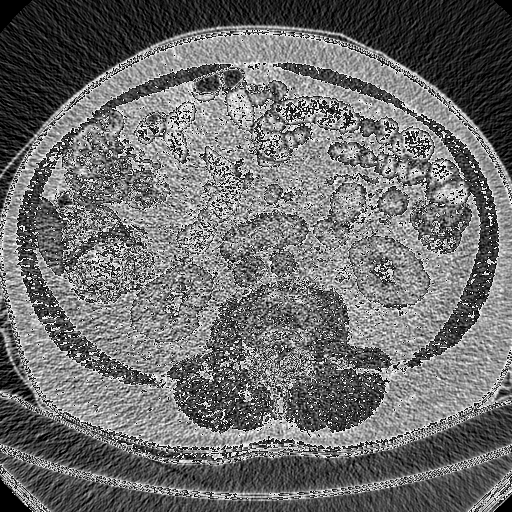

In [38]:
ct_img

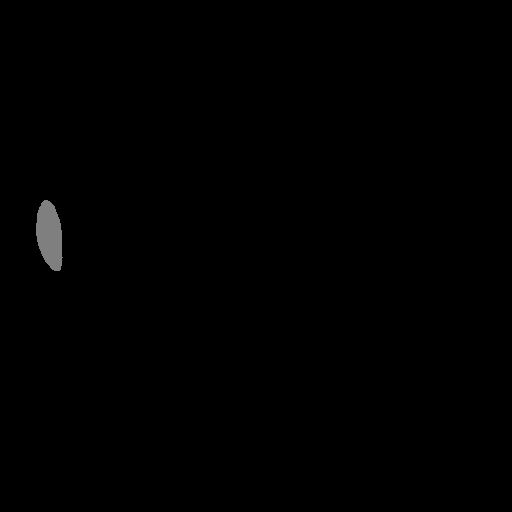

In [36]:
seg_img

In [19]:
good_slices = get_good_slices(seg_array)
good_slices

[322,
 323,
 324,
 372,
 373,
 374,
 375,
 376,
 377,
 378,
 379,
 380,
 381,
 382,
 383,
 384,
 385,
 386,
 387,
 388,
 389,
 390,
 391,
 392,
 393,
 394,
 395,
 396,
 397,
 398,
 399,
 400,
 401,
 402,
 403,
 404,
 405,
 406,
 407,
 408,
 409,
 410,
 411,
 412,
 413,
 414,
 415,
 416,
 417,
 418,
 419,
 420,
 421,
 422,
 423,
 424,
 425,
 426,
 427,
 428,
 429,
 430,
 431,
 432,
 433,
 434,
 435,
 436,
 437,
 438,
 439,
 440,
 441,
 442,
 443,
 444,
 445,
 446,
 447,
 448,
 449,
 450,
 451,
 452,
 453,
 454,
 455,
 456,
 457,
 458,
 459,
 460,
 461,
 462,
 463,
 464,
 465,
 466,
 467,
 468,
 469,
 470,
 471,
 472,
 473,
 474,
 475,
 476,
 477,
 478,
 479,
 480,
 481,
 482,
 483,
 484,
 485,
 486,
 487,
 488,
 489,
 490,
 491,
 492,
 493,
 494,
 495,
 496,
 497,
 498,
 499,
 500,
 501,
 502,
 503,
 504,
 505,
 506,
 507,
 508,
 509,
 510,
 511,
 512,
 513,
 514,
 515,
 516,
 517,
 518,
 519,
 520,
 521,
 522,
 523,
 524,
 525,
 526,
 527,
 528,
 529,
 530,
 531,
 532,
 533,
 534,
 535

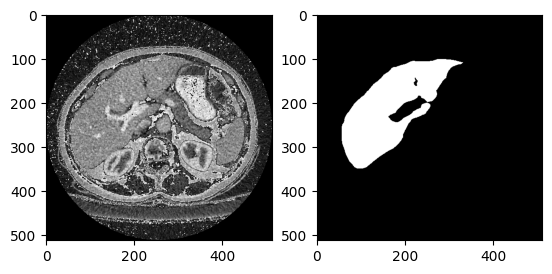

In [10]:
from training_scripts.LITS17Dataset import LITS17Dataset
from transformers import CLIPTokenizer
import os
import matplotlib.pyplot as plt

ct_dir = '/disk4/Lev/Projects/diffusion_finetuning/data/lits17/train'
vol_pkl = os.path.join(ct_dir, 'lits_train_vol_files_good_slices.pickle')
seg_pkl = os.path.join(ct_dir, 'lits_train_seg_files_good_slices.pickle')
lits17ds = LITS17Dataset(ct_dir,
                         ct_dir,
                         prompt='segmentation map of liver',
                         path_slices_for_segmap=seg_pkl,
                         path_slices_for_vol=vol_pkl)

example = lits17ds[100]
ct = example['instance_image'] # torch tensor
seg = example['instance_segmap_image'] # torch tensor

ct = convert_tensor_to_img(ct, True)
seg = convert_tensor_to_img(seg, True)

fig, ax = plt.subplots(1, 2)
ax[0].imshow(ct, cmap='gray')
ax[1].imshow(seg)
plt.show()

In [40]:
# Makes sure that the lists are aligned

lst_vol = lits17ds.ct_list_w_slices
lst_seg = lits17ds.seg_list_w_slices

i = 0
for vol, seg in zip(lst_vol, lst_seg):
    if vol[0] != seg[0].replace('segmentation', 'volume') or vol[1] != seg[1]:
        print(vol, '\n', seg, '\n\n')